In [3]:
import pandas as pd
import nump as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'nump'

In [6]:
def concat_df(train_data,test_data):
    return pd.concat([train_data,test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    return all_data.loc[:890],all_data.loc[891:].drop(['Survived'],axis=1)

train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
df_all = concat_df(train_df,test_df)

train_df.name = 'Training Set'
test_df.name = 'Test Set'
df_all.name = 'All Set'

dfs = [train_df,test_df]

print('Number of Training Examples = {}'.format(train_df.shape[0]))
print('Number of Test Examples = {}'.format(test_df.shape[0]))
print(train_df.columns)
print(test_df.columns)



Number of Training Examples = 891
Number of Test Examples = 418
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


## **1. Exploratory Data Analysis**

In [71]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


In [72]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [73]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

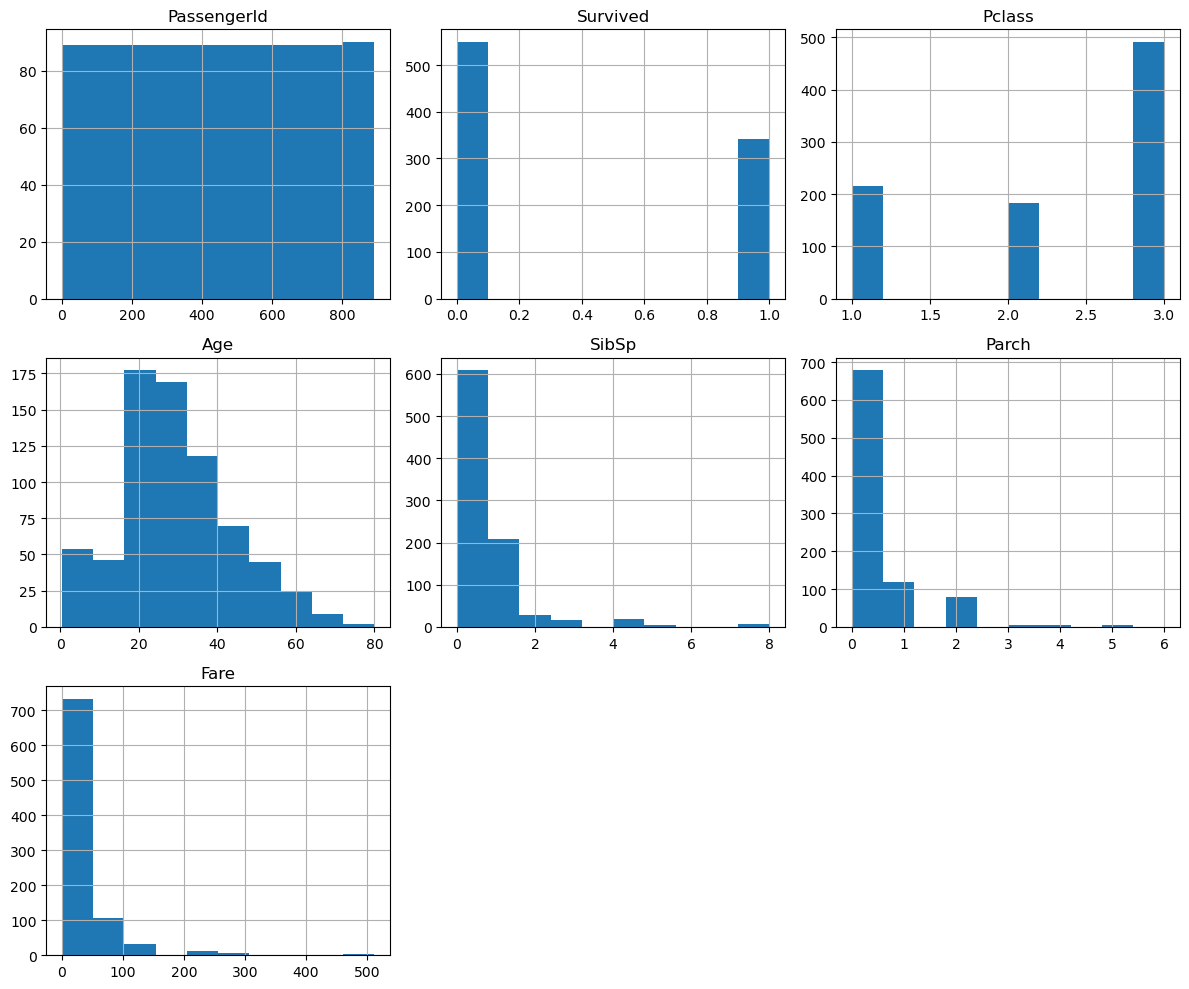

In [74]:
import matplotlib.pyplot as plt
train_df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

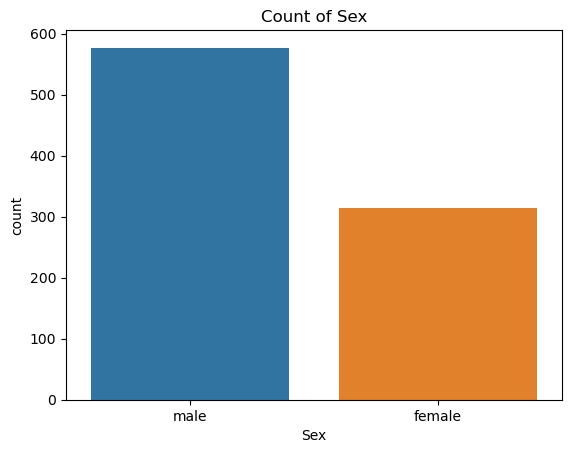

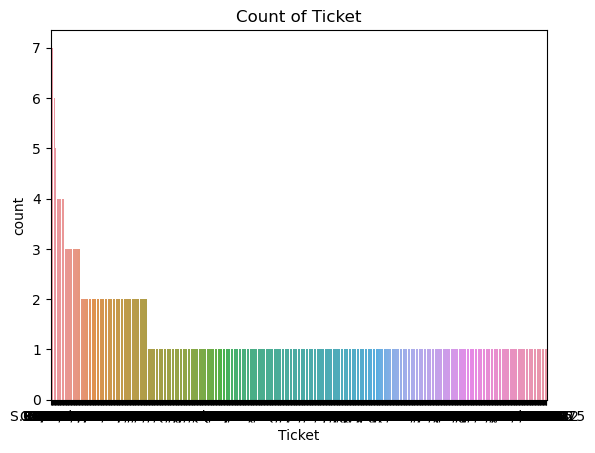

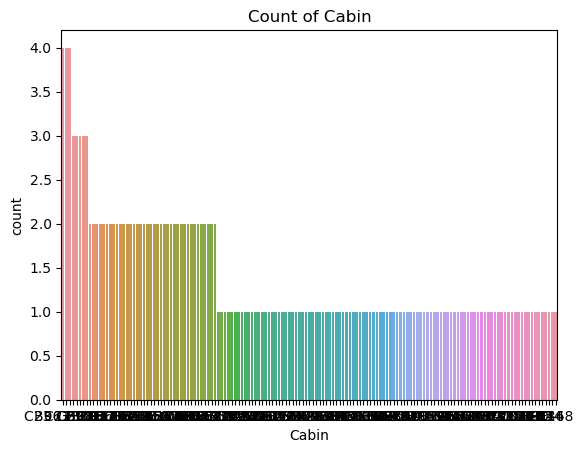

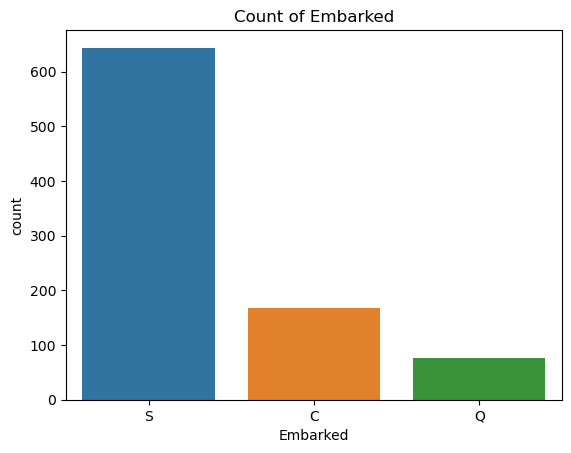

In [75]:
import seaborn as sns
train_df_cat = train_df[['Sex','Ticket','Cabin','Embarked']]

for i in train_df_cat.columns:
    sns.barplot(x=train_df_cat[i].value_counts().index,y=train_df_cat[i].value_counts()).set_title(f"Count of {i}")
    plt.show()

In [76]:
# compare survival rate across Age, SibSp, Parch, and Fare 
print(pd.pivot_table(train_df, index = 'Survived', values = ['Age','SibSp','Parch','Fare']))
print()
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
#seems like class does have an impact too, 1st class has higher survival rate
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
#more male died because women and children to safety first policy?
print(pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))
#Seens like those who embarked on S has a higher chance of survival

                Age       Fare     Parch     SibSp
Survived                                          
0         30.626179  22.117887  0.329690  0.553734
1         28.343690  48.395408  0.464912  0.473684

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
import statistics

1.2 Missing Values

In [9]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col,df[col].isnull().sum()))
    print('\n')

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




Age

In [12]:
df_all_corr = df_all.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


Sex

In [13]:
age_by_pclass_sex = df_all.groupby(['Sex','Pclass']).median()['Age']

for pclass in range(1,4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass,sex,age_by_pclass_sex[sex][pclass]))
    print('Median age of all passengers: {}'.format(df_all['Age'].median()))

df_all['Age'] = df_all.groupby(['Sex','Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

TypeError: agg function failed [how->median,dtype->object]

In [78]:
# Feature Engineering
for df in [train_df, test_df]:
    df['cabin_multiple'] = df.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
    df['cabin_adv'] = df.Cabin.apply(lambda x: str(x)[0])
    df['numeric_ticket'] = df.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
    df['ticket_letters'] = df.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) > 0 else '0')
    df['name_title'] = df.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['family_size'] = df['SibSp'] + df['Parch'] + 1  # +1 to include the individual themselves

In [79]:
# Drop irrelevant columns
train_df.drop(columns=['Name', 'Ticket', 'Cabin', 'ticket_letters','SibSp', 'Parch'], inplace=True)
test_df.drop(columns=['Name', 'Ticket', 'Cabin', 'ticket_letters','SibSp', 'Parch'], inplace=True)

In [80]:
# # Handle Missing Values
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Fare'] = train_df['Fare'].fillna(train_df['Fare'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

In [81]:
# Combine Train and Test DataFrames
train_df['train_test'] = 1
test_df['train_test'] = 0
combined_df = pd.concat([train_df, test_df])

In [82]:
combined_df['Embarked'] = combined_df['Embarked'].fillna('S')

In [83]:
# Apply One-Hot Encoding on Combined DataFrame
combined_dummies = pd.get_dummies(combined_df, columns=['Pclass', 'Sex', 'Embarked', 'cabin_multiple', 'numeric_ticket', 'name_title', 'cabin_adv'])

In [84]:
pd.reset_option('display.max_columns')

In [85]:
combined_dummies

,PassengerId,Survived,Age,Fare,family_size,train_test,Pclass_1,Pclass_2,Pclass_3,Sex_female,...,name_title_the Countess,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n
0,1,0.0,22.0,7.2500,2,1,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
1,2,1.0,38.0,71.2833,2,1,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
2,3,1.0,26.0,7.9250,1,1,False,False,True,True,...,False,False,False,False,False,False,False,False,False,True
3,4,1.0,35.0,53.1000,2,1,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
4,5,0.0,35.0,8.0500,1,1,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,27.0,8.0500,1,0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
414,1306,NaN,39.0,108.9000,1,0,True,False,False,True,...,False,False,False,True,False,False,False,False,False,False
415,1307,NaN,38.5,7.2500,1,0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
416,1308,NaN,27.0,8.0500,1,0,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True


In [86]:
# Separate the Combined DataFrame back into Train and Test DataFrames
train_dummies = combined_dummies[combined_dummies['train_test'] == 1].drop(['train_test'], axis=1)
test_dummies = combined_dummies[combined_dummies['train_test'] == 0].drop(['train_test', 'Survived'], axis=1)

In [87]:
# Align the Columns in Test_dummies to Match Train_dummies
missing_cols = set(train_dummies.columns) - set(test_dummies.columns)
for col in missing_cols:
    test_dummies[col] = 0

In [88]:
# Ensure the Order of Columns in Test_dummies Matches Train_dummies
test_dummies = test_dummies[train_dummies.columns.drop('Survived')]

In [89]:
# Scale Numerical Features
scaler = StandardScaler()
numerical_features = ['Age', 'Fare']
train_dummies[numerical_features] = scaler.fit_transform(train_dummies[numerical_features])
test_dummies[numerical_features] = scaler.transform(test_dummies[numerical_features])

In [90]:
# Prepare Data for Model Training
X = train_dummies.drop(['Survived'], axis=1)
y = train_dummies['Survived']
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [91]:
# Define Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=300, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': svm.SVC(C=1),
    'XGBoost': XGBClassifier(learning_rate=0.1, random_state=42)
}

In [92]:
# Evaluate Models using KFold Cross-Validation
for model_name, model in models.items():
    kfold_accuracy = cross_val_score(model, X, y, cv=kf)
    print(f'{model_name} accuracy score:', statistics.mean(kfold_accuracy))

Logistic Regression accuracy score: 0.8260299625468165
Decision Tree accuracy score: 0.7710486891385768
K-Neighbors accuracy score: nan
Random Forest accuracy score: 0.8147815230961298
SVM accuracy score: 0.6161797752808988
XGBoost accuracy score: 0.8248938826466916


In [93]:
param_grid_xgb = {
    'max_depth': [3, 10, 20, 30],
    'min_child_weight': [1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'n_estimators': [100, 200, 300]
}

grid_search_xgb = GridSearchCV(estimator=models['XGBoost'], param_grid=param_grid_xgb, cv=kf)
grid_search_xgb.fit(X, y)
XGB_model = grid_search_xgb.best_estimator_

print('Hypertuned XGB CV accuracy:', statistics.mean(cross_val_score(XGB_model, X, y, cv=kf)))
#Hypertuned XGB CV accuracy: 0.8395131086142322

Hypertuned XGB CV accuracy: 0.8395006242197254


In [94]:
param_grid_logreg = {
    'max_iter': [50, 100, 200]
}

grid_search_logreg = GridSearchCV(estimator=models['Logistic Regression'], param_grid=param_grid_logreg, cv=kf)
grid_search_logreg.fit(X, y)
log_reg_model = grid_search_logreg.best_estimator_

print('Hypertuned LogReg CV accuracy:', statistics.mean(cross_val_score(log_reg_model, X, y, cv=kf)))
#Hypertuned LogReg CV accuracy: 0.8260299625468165

Hypertuned LogReg CV accuracy: 0.8260299625468165


In [95]:
from sklearn.model_selection import RandomizedSearchCV
param_dist_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

random_search_svm = RandomizedSearchCV(estimator=models['SVM'], param_distributions=param_dist_svm, n_iter=10, cv=5, n_jobs=-1)
random_search_svm.fit(X, y)
SVM_model = random_search_svm.best_estimator_
print('Hypertuned SVM CV accuracy:', statistics.mean(cross_val_score(SVM_model, X, y, cv=5)))
#Hypertuned SVM CV accuracy: 0.8271608813006088

Hypertuned SVM CV accuracy: 0.8271608813006088


In [96]:
# Use the Best Model to Make Predictions
test_predictions = SVM_model.predict(test_dummies).astype(int)
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

In [97]:
submission.to_csv('SVM_submission_030624.csv', index=False)
